In [20]:
#from board import experiment
import numpy as np
from scipy.stats import skew, mode
from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#n_data = 1000 # Number of times to run the experiment

#data = np.zeros((n_data, 32))
#for i in range(0, n_data):
#    print(f"{i+1}/{n_data}\r", end="")
#    data[i,:] = experiment()

#np.save("experiment_data.npy", data)

In [71]:
# Loads data from experiment_data.npy file
# Contains data for 1000 experiments
# If we need more data I can only do it on the computers at Chalmers
experiment_data = np.load("experiment_data.npy")
n_experiment = experiment_data.shape[0]

# Dummy experiment function that reads pregenerated data
i_experiment = 0
def experiment():
    global i_experiment
    result = experiment_data[i_experiment,:]
    i_experiment = i_experiment+1
    if i_experiment >= n_experiment: 
        i_experiment = 0
        print("Warning: reusing old experiments")
    return result

In [72]:
def summary_statistics(data):
    # Some summary statistics. Skew gives some kind of distribution atleast, see plot in last cell
    mean = np.mean(data)
    var = np.var(data)
    skewness = skew(data)
    mode_value = mode(data).mode[0]

    return np.array([mean, var, skewness, mode_value])

def gaussian_kernel(dist, h):
    return np.exp(-dist**2 / (2 * h**2))

def biweight_kernel(dist, h):
    if abs(dist) <= h:
        return 15/16 * ((1 - (dist / h) ** 2) ** 2)
    else:
        return 0

def simulate_exp(alpha, s, num_rows = 31):
    # Simulates an experiment for given alpha and s values
    num_beads = num_rows + 1 # Number of beads at the bottom of the Galton board
    results = np.zeros(num_beads)
    
    for _ in range(1000):  # Number of balls
        M = 0  # Initial memory factor
        pos = (num_rows) / 2  # Starting position
        
        # Iterate over each row of pegs
        for ix in range(num_rows):
            # Calculate the probability of falling right
            P_right = 0.5 + (alpha * M + s)

            # Random decision for the bead's direction
            if np.random.uniform(0, 1) < P_right:
                pos += 0.5  # Move right
                M = 0.5  # Update memory factor
            else:
                pos -= 0.5  # Move left
                M = -0.5  # Update memory factor

        # Determine the final position of the ball
        pos = int(np.round(pos))
        results[pos] += 1

    return results

def abc_rejection_sampling(data_obs, h, num_simulations=10):
    accepted_alphas = []
    # Loop over the number of simulations
    for ix in tqdm(range(num_simulations)):
        # Iterate through each experiment in the observed data
        for jx in range(len(data_obs)):
            observed_exp = experiment()  # Generate experiment data, see code above
            ss_obs = summary_statistics(observed_exp)[2]
        
            # Randomly sample alpha and s
            alpha = np.random.uniform(0, 0.5)
            s = np.random.uniform(-0.25, 0.25)
        
            # Simulate an experiment with the sampled parameters
            sim_exp = simulate_exp(alpha, s)
            ss_exp = summary_statistics(sim_exp)[2]

            dist = ss_obs - ss_exp

            # Calculate kernel
            w = biweight_kernel(dist, h)
            
            # If w is higher than a random threshold, accept alpha
            if w > np.random.uniform(0, 1):
                accepted_alphas.append(alpha)
    return accepted_alphas


Text(0, 0.5, 'freq.')

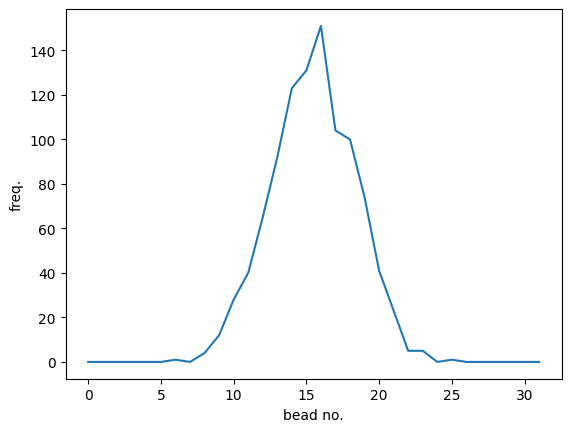

In [69]:
s = simulate_exp(0, 0.)
x = experiment_data[0]
plt.plot(s)
plt.xlabel('bead no.')
plt.ylabel('freq.')

In [41]:
i_experiment = 0
num_simulations = 20
h = 0.1
print(len(experiment_data))
accepted_alphas_skew_biweight = abc_rejection_sampling(experiment_data, h, num_simulations)

1000


  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/61/lqmc5d7s7qv5yywzjmbds8v80000gn/T/ipykernel_3100/636044804.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_value = mode(data).mode[0]


2222


<function matplotlib.pyplot.show(close=None, block=None)>

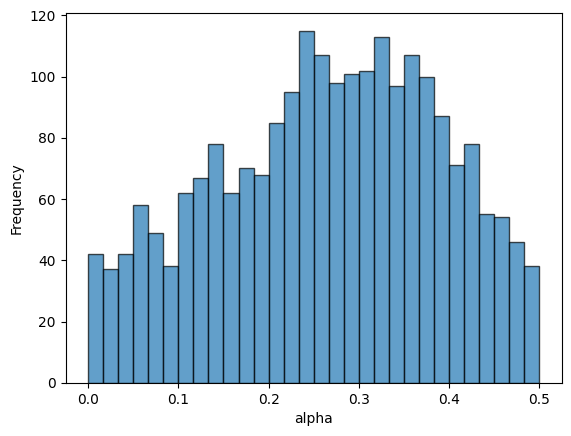

In [76]:
print(len(accepted_alphas_skew_biweight))
plt.hist(accepted_alphas_skew_biweight, bins = 30, edgecolor = 'black', alpha = 0.7)
plt.xlabel('alpha')
plt.ylabel('Frequency')
plt.show